# Precios de casas en Amex, IOWA

Trabajo en grupo para el diplomado de la Universidad de la Sabana

## Importar dependencias

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

## Cargar los datos

Usamos "logaritmo de uno más" en los precios de las casas porque esto nos ayuda a comprimir los valores y produce mejores resultados

In [2]:
train_data = pd.read_csv('https://github.com/juanloprib/ai-toy-datasets/blob/main/house-prices-iowa/train.csv?raw=true')
train_data_features = train_data.drop('SalePrice', axis=1)
train_data_target = np.log1p(train_data['SalePrice'])

## Clase para analizar los datos

Creamos esta clase que usaremos antes y después de preprocesar los datos para estar seguros que los datos están como queremos antes de entrenar el modelo

In [3]:
from pandas import DataFrame

class AnalyzeData:
    def __init__(self, features: DataFrame, target: DataFrame):
        self.features: DataFrame = features
        self.target: DataFrame = target
        self.max_skew = 1.2
        self.min_skew = -1.2


    def update_data(self, features: DataFrame, target: DataFrame):
        self.features = features
        self.target = target


    def analyze(self):
        print("Dataset analysis:")
        if self.has_empty_values():
            print(f"⛔ The dataset has empty values in columns")
        else:
            print("✅ The dataset has no empty values")
        if self.has_duplicated_rows():
            print(f"⛔ The dataset has {self.has_duplicates()} duplicated rows")
        else:
            print("✅ The dataset has no duplicated rows")
        if self.has_duplicated_cols():
            print(f"⛔ The dataset has {self.has_duplicated_cols()} duplicated columns")
        else:
            print("✅ The dataset has no duplicated columns")
        if not self.all_rows_have_target():
            print("⛔ Not all rows have target values")
        else:
            print("✅ All rows have target values")
        if self.has_object_cols():
            print("⛔ The dataset has object columns")
        else:
            print("✅ The dataset has no object columns")
        """ if self.is_skewed():
            print("⛔ The dataset has skewed columns")
        else:
            print("✅ The dataset has no skewed columns") """
        print()


    def is_skewed(self):
        return self.features.skew().any() > self.max_skew or self.features.skew().any() < self.min_skew


    def has_empty_values(self):
        return self.features.isnull().values.any() or self.target.isnull().values.any()


    def has_duplicated_rows(self):
        return self.features.duplicated().sum()


    def has_duplicated_cols(self):
        return self.features.columns.duplicated().sum()


    def all_rows_have_target(self):
        return len(self.features) == len(self.target)


    def has_object_cols(self):
        return self.features.select_dtypes(include=['object']).columns.any()


    def basic_info(self):
        self.print_all_vals()
        self.custom_info_table()
        print(self.features.describe(), end='\n\n')
        self.categorical_info()
        print(self.target.describe(), end='\n\n')
        self.print_default_vals()


    def custom_info_table(self):
        data_info = pd.DataFrame(self.features.columns, columns=['Column'])
        data_info['Data Type'] = self.features.dtypes.values
        data_info['Nulls'] = self.features.isnull().sum().values
        data_info['Nulls %'] = (self.features.isnull().sum().values / len(self.features) * 100).round(2)
        data_info['Unique Values'] = self.features.nunique().values
        print(data_info, end='\n\n')


    def categorical_info(self):
        categorical_cols = self.features.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            print(col, self.features[col].unique(), len(self.features[col].unique()))
        print()


    def print_all_vals(self):
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)


    def print_default_vals(self):
        pd.reset_option('display.max_rows')
        pd.reset_option('display.max_columns')

## Analizamos los datos

In [4]:
analyzer = AnalyzeData(train_data_features, train_data_target)
analyzer.basic_info()
analyzer.analyze()

           Column Data Type  Nulls  Nulls %  Unique Values
0              Id     int64      0     0.00           1460
1      MSSubClass     int64      0     0.00             15
2        MSZoning    object      0     0.00              5
3     LotFrontage   float64    259    17.74            110
4         LotArea     int64      0     0.00           1073
5          Street    object      0     0.00              2
6           Alley    object   1369    93.77              2
7        LotShape    object      0     0.00              4
8     LandContour    object      0     0.00              4
9       Utilities    object      0     0.00              2
10      LotConfig    object      0     0.00              5
11      LandSlope    object      0     0.00              3
12   Neighborhood    object      0     0.00             25
13     Condition1    object      0     0.00              9
14     Condition2    object      0     0.00              8
15       BldgType    object      0     0.00             

## Eliminar columnas

Eliminamos la columna Id porque no es útil durante el entrenamiento

In [5]:
cols_to_drop = ['Id']
train_data_features.drop(cols_to_drop, axis=1, inplace=True)

## Imputación de datos

In [6]:
cols_vals_to_fill = {
    'LotFrontage': train_data_features['LotFrontage'].mean(),
    'Alley': 'No alley access',
    'MasVnrType': 'None',
    'MasVnrArea': 0,
    'BsmtQual': 'No basement',
    'BsmtCond': 'No basement',
    'BsmtExposure': 'No basement',
    'BsmtFinType1': 'No basement',
    'BsmtFinType2': 'No basement',
    'Electrical': train_data_features['Electrical'].mode()[0],
    'FireplaceQu': 'No fireplace',
    'GarageType': 'No garage',
    'GarageYrBlt': train_data_features['GarageYrBlt'].min(),
    'GarageFinish': 'No garage',
    'GarageQual': 'No garage',
    'GarageCond': 'No garage',
    'PoolQC': 'No pool',
    'Fence': 'No fence',
    'MiscFeature': 'None'
}
train_data_features.fillna(value=cols_vals_to_fill, inplace=True)

## Eliminar filas con posibles errores

Notamos que una fila tiene datos que no concuerdan para el sótano, así que la eliminamos

In [7]:
for index, row in train_data_features.iterrows():
    if row['BsmtExposure'] == 'No basement' and row['BsmtCond'] != 'No basement':
        train_data_features.drop(index, inplace=True)
        train_data_target.drop(index, inplace=True)

## Categorías ordinales

Ordenamos las categorías desde la de menor valor a la de mayor valor

In [8]:
ordinal_mappings = {
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandContour': ['Low', 'HLS', 'Bnk', 'Lvl'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['No basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['No basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['No basement', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['No basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['No basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'CentralAir': ['N', 'Y'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['No fireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['No garage', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['No garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['No garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC': ['No pool', 'Fa', 'TA', 'Gd', 'Ex'],
}

for col, categories in ordinal_mappings.items():
    ordinal_encoder = OrdinalEncoder(categories=[categories])
    train_data_features[col] = ordinal_encoder.fit_transform(train_data_features[[col]])

## Categorías nominales

Usamos OneHotEncoder

In [9]:
nominal_categories = [
    'MSZoning',
    'Street',
    'Alley',
    'LotConfig',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'MasVnrType',
    'Foundation',
    'Heating',
    'Electrical',
    'GarageType',
    'PavedDrive',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition',
]
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
nominal_encoded = onehot_encoder.fit_transform(train_data_features[nominal_categories])
nominal_encoded = pd.DataFrame(nominal_encoded, columns=onehot_encoder.get_feature_names_out(nominal_categories))
nominal_encoded.index = train_data_features.index
train_data_features.drop(nominal_categories, axis=1, inplace=True)
train_data_features = pd.concat([train_data_features, nominal_encoded], axis=1)

## Frequency encoding

Para las columnas que tenían muchas opciones usamos frequency encoding para no tener que generar tantas columnas extra

In [10]:
cols_to_freq_encode = [
    'Neighborhood',
    'Exterior1st',
    'Exterior2nd',
]
for col in cols_to_freq_encode:
    freqs = train_data_features[col].value_counts(normalize=True)
    train_data_features[col] = train_data_features[col].map(freqs)

## Sesgo de datos

Revisamos cuáles columnas tienen datos muy sesgados, por encima de 1.2 y en estos usamos logaritmo de 1 más para comprimirlos.

* Hicimos la prueba con y sin comprimir los datos con logaritmo y efectivamente mejora el score si se usa logaritmo pero solo en los skew muy positivos
* Los skew muy negativos no beneficiaban el resultado si se comprimían



In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(train_data_features.skew())
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

high_skew_features = train_data_features.skew()[train_data_features.skew() > 1.2].index
train_data_features[high_skew_features] = np.log1p(train_data_features[high_skew_features])

MSSubClass                1.407334
LotFrontage               2.383800
LotArea                  12.205740
LotShape                 -1.312302
LandContour              -3.464919
Utilities               -38.196859
LandSlope                -4.811833
Neighborhood              0.885674
OverallQual               0.218116
OverallCond               0.692052
YearBuilt                -0.612534
YearRemodAdd             -0.502431
Exterior1st               0.238153
Exterior2nd               0.287736
MasVnrArea                2.677300
ExterQual                 0.828014
ExterCond                 1.396342
BsmtQual                 -1.286517
BsmtCond                 -3.699580
BsmtExposure              1.104546
BsmtFinType1             -0.160638
BsmtFinSF1                1.685198
BsmtFinType2              3.295574
BsmtFinSF2                4.253594
BsmtUnfSF                 0.921933
TotalBsmtSF               1.523298
HeatingQC                -0.539366
CentralAir               -3.528901
1stFlrSF            

## Analizar nuevamente

Todos los test pasan 🎉

In [12]:
analyzer.update_data(train_data_features, train_data_target)
analyzer.basic_info()
analyzer.analyze()

                    Column Data Type  Nulls  Nulls %  Unique Values
0               MSSubClass   float64      0      0.0             15
1              LotFrontage   float64      0      0.0            111
2                  LotArea   float64      0      0.0           1072
3                 LotShape   float64      0      0.0              4
4              LandContour   float64      0      0.0              4
5                Utilities   float64      0      0.0              2
6                LandSlope   float64      0      0.0              3
7             Neighborhood   float64      0      0.0             23
8              OverallQual     int64      0      0.0             10
9              OverallCond     int64      0      0.0              9
10               YearBuilt     int64      0      0.0            112
11            YearRemodAdd     int64      0      0.0             61
12             Exterior1st   float64      0      0.0             12
13             Exterior2nd   float64      0     

## Dividir data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data_features,
    train_data_target,
    test_size=0.2,
    random_state=42
)
y_test = np.expm1(y_test)

## LinearRegression

In [14]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
pipe.fit(X_train, y_train)
predictions = np.expm1(pipe.predict(X_test))

print("\nLinearRegression:")
print("MAE", mean_absolute_error(y_test, predictions))
print("MSE", mean_squared_error(y_test, predictions))
print("RMSE", root_mean_squared_error(y_test, predictions))
print("R2", r2_score(y_test, predictions))


LinearRegression:
MAE 15698.133154665777
MSE 629009706.3094915
RMSE 25080.065915174375
R2 0.894069484645093


## Ridge

Nos dio mejores resultados

In [15]:
pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("model", Ridge())
])
pipe.fit(X_train, y_train)
predictions =  np.expm1(pipe.predict(X_test))

print("\nRidge:")
print("MAE", mean_absolute_error(y_test, predictions))
print("MSE", mean_squared_error(y_test, predictions))
print("RMSE", root_mean_squared_error(y_test, predictions))
print("R2", r2_score(y_test, predictions))


Ridge:
MAE 14405.339205826442
MSE 408526176.3216185
RMSE 20212.030484877527
R2 0.9312007621509963


## Graficar resultados

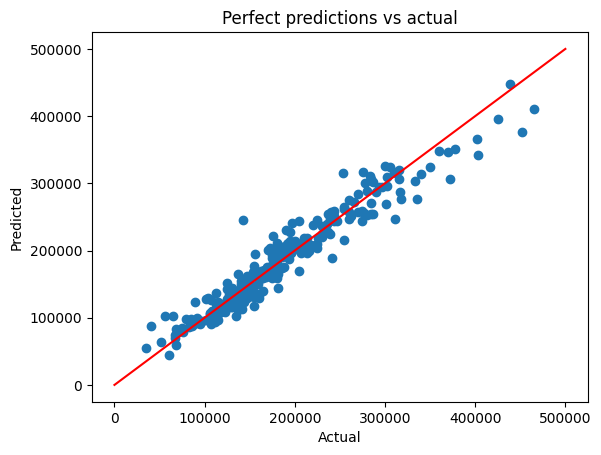

In [16]:
plt.scatter(y_test, predictions)
plt.plot([0, 500000], [0, 500000], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Perfect predictions vs actual')
plt.show()